<a href="https://www.kaggle.com/code/riyosha/rwanda-co2-prediction?scriptVersionId=191938768" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


Exploratory Data Analysis

In [2]:
# this notebook has picked many ideas from ambrosm's notebook on this dataset
# https://www.kaggle.com/code/ambrosm/pss3e20-eda-which-makes-sense/notebook


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [4]:
data_path = '/kaggle/input/playground-series-s3e20'
train_data = pd.read_csv(data_path+'/train.csv')
test_data = pd.read_csv(data_path+'/test.csv')
samplesubmission = pd.read_csv(data_path+'/sample_submission.csv')


In [5]:
train_data.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [6]:
test_data.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,...,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,...,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,...,34133.080469,8984.795703,39006.093750,7984.795703,10.753179,0.267130,39.087361,45.936480,-144.784988,26.743361
3,ID_-0.510_29.290_2022_03,-0.51,29.29,2022,3,0.000350,0.696917,0.000243,0.201028,72.169566,...,50854.991076,6014.724059,57646.368368,5014.724115,11.764556,0.304679,-24.465127,42.140419,-135.027891,29.604774
4,ID_-0.510_29.290_2022_04,-0.51,29.29,2022,4,-0.000317,0.580527,-0.000184,0.204352,76.190865,...,46594.685145,6849.280477,52896.541873,5849.280394,13.065317,0.284221,-12.907850,30.122641,-135.500119,26.276807


In [7]:
samplesubmission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,81.94
1,ID_-0.510_29.290_2022_01,81.94
2,ID_-0.510_29.290_2022_02,81.94
3,ID_-0.510_29.290_2022_03,81.94
4,ID_-0.510_29.290_2022_04,81.94


In [8]:
train_data.shape, test_data.shape, samplesubmission.shape

((79023, 76), (24353, 75), (24353, 2))

In [9]:
test_data.shape[0]/train_data.shape[0]

0.3081761006289308

Statistical Description

In [10]:
'''
We can see that - 
1. Time range of data is from 2019 to 2021, and weekly data is provided
2. Min and Max emmissions are 0 to 3167.768
'''
train_data.describe(include='all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023,79023.000000,79023.000000,79023.000000,79023.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,...,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,79023.000000
unique,79023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-0.510_29.290_2019_00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-1.891072,29.880155,2020.000000,26.000000,0.000048,0.834848,0.000035,0.158418,-7.925870,...,5592.377478,59420.297456,4670.430869,19.139241,0.271460,-10.784832,40.436976,-86.800583,27.925981,81.940552
std,NaN,0.694522,0.810375,0.816502,15.297155,0.000272,0.185382,0.000206,0.071364,64.263368,...,1428.503002,9051.163609,1359.251583,13.547047,0.049434,30.374462,6.428216,37.837269,4.403835,144.299648
min,NaN,-3.299000,28.228000,2019.000000,0.000000,-0.000996,0.241822,-0.000887,0.000000,-179.537059,...,1050.661782,24779.033704,1050.496816,1.844529,0.017697,-102.739731,2.998873,-153.464211,10.818288,0.000000
25%,NaN,-2.451000,29.262000,2019.000000,13.000000,-0.000096,0.705817,-0.000078,0.110535,-56.782383,...,4595.400519,53175.779928,3680.856344,9.974574,0.241453,-30.309170,35.829907,-125.991158,24.686763,9.797995
50%,NaN,-1.882000,29.883000,2020.000000,26.000000,0.000024,0.809118,0.000019,0.161855,-12.441726,...,5573.854309,59332.532548,4621.755170,15.130688,0.272747,-12.673914,41.119630,-84.644352,28.333630,45.593445
75%,NaN,-1.303000,30.471000,2021.000000,39.000000,0.000153,0.942792,0.000121,0.211824,72.059990,...,6542.303642,65663.842684,5572.983223,23.785030,0.302892,9.402202,44.446272,-48.132701,31.499883,109.549595


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


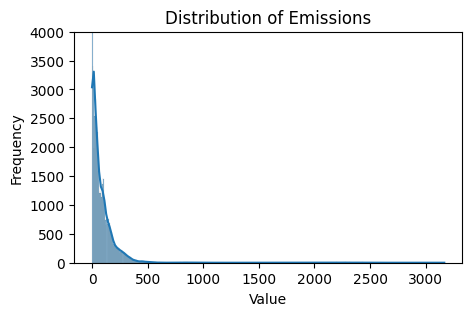

Skew:  10.173825825101622


In [11]:
# Let's check out the distribution of the data 
plt.figure(figsize=(5, 3))
sns.histplot(train_data['emission'], kde=True)
plt.title('Distribution of Emissions')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.ylim(0, 4000) 
plt.show()

print('Skew: ', train_data['emission'].skew()) # skewed to the right - we'll figure out how to handle this (if needed) while building our model

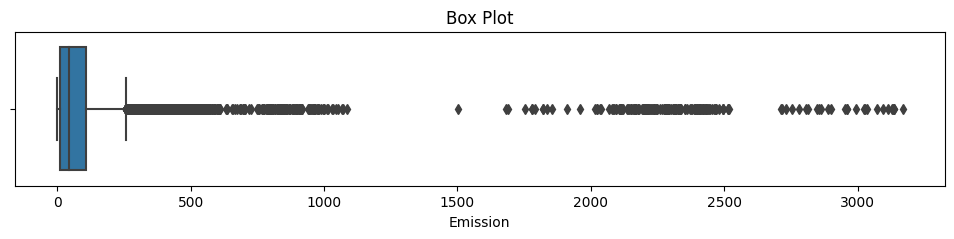

In [12]:
plt.figure(figsize=(12, 2))
sns.boxplot(x=train_data['emission'])
plt.title('Box Plot')
plt.xlabel('Emission')
plt.show()

# most of the emissions are below 500

In [13]:
#missing values

print('Rows with at least 1 missing value: ', train_data.isna().any(axis=1).sum())

# almost all rows have some missing value, so we can't just drop the missing values. 
# We'll handle missing values EDA, before we train our model

Rows with at least 1 missing value:  78585


In [14]:
# Let's find out how many geographical points we have

print(train_data.groupby(['latitude', 'longitude']).size().sort_values())
print(test_data.groupby(['latitude', 'longitude']).size().sort_values())

# there are 497 distinct geographical points, each of which have 159 data points in training set
# and 49 data points in the test set

latitude  longitude
-3.299    30.301       159
-1.444    30.856       159
-1.450    29.350       159
-1.482    30.618       159
-1.486    29.614       159
                      ... 
-2.293    29.507       159
-2.300    29.200       159
-2.301    29.899       159
-2.257    30.243       159
-0.510    29.290       159
Length: 497, dtype: int64
latitude  longitude
-3.299    30.301       49
-1.444    30.856       49
-1.450    29.350       49
-1.482    30.618       49
-1.486    29.614       49
                       ..
-2.293    29.507       49
-2.300    29.200       49
-2.301    29.899       49
-2.257    30.243       49
-0.510    29.290       49
Length: 497, dtype: int64


In [15]:
# we can analyse emissions according to these 497 points
point_mean_emissions = train_data.groupby(['latitude','longitude']).emission.mean().sort_values()
point_mean_emissions

# alot of these points have mean 0 emissions => their prediction should likely be 0

latitude  longitude
-1.682    29.218          0.000000
-2.859    29.041          0.000000
-1.833    28.467          0.000000
-2.841    29.159          0.000000
-1.974    28.526          0.000000
                          ...     
-1.342    31.358        409.606870
-0.956    30.744        455.398039
-1.346    31.254        475.289138
-2.079    29.321       1221.886518
-2.378    29.222       2233.431628
Name: emission, Length: 497, dtype: float64

Geo Visualisation

In [16]:
# Let's visualise these points on a map 

import geopandas as gpd # geosatial data visualisation
from shapely.geometry import Point # representing data as a 2d or 3d point
import folium # for interactive maps
import matplotlib.colors as mcolors


In [17]:
# we can get a heat map of these points on the geographic map 

point_mean_emissions = point_mean_emissions.reset_index()
geometry = gpd.points_from_xy(point_mean_emissions.longitude, point_mean_emissions.latitude)

# Create point geometries
geometry = gpd.points_from_xy(point_mean_emissions.longitude, point_mean_emissions.latitude)
geo_df = gpd.GeoDataFrame(
    point_mean_emissions, geometry=geometry
)

train_coords_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

norm = plt.Normalize(vmin=np.log1p(point_mean_emissions.emission.min()), vmax=np.log1p(point_mean_emissions.emission.max()))
cmap = plt.get_cmap('coolwarm') 

def get_color(emission):
    return mcolors.to_hex(cmap(norm(np.log1p(emission))))
i=0
# Iterate through list and add a marker for each emission point
for coordinates in geo_df_list: 
    emiss = point_mean_emissions[(point_mean_emissions['latitude']==coordinates[0]) & (point_mean_emissions['longitude']==coordinates[1])]
    emiss = emiss['emission'].iloc[0]
    color = get_color(emiss)
    # Place the markers 
    train_coords_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            fill=True,
            popup= 
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color = color),
        )
    i = i + 1
train_coords_map.fit_bounds(train_coords_map.get_bounds())
train_coords_map

# looks like the higher emission points are more centrally located.
# also, longitude decides the emission level much more than a point's latitude

Timeseries EDA

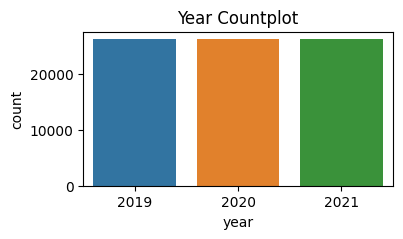

In [18]:
#now let's analyse this data as a timeseries

plt.figure(figsize=(4,2))
sns.countplot(x='year', data=train_data)
plt.title('Year Countplot')
plt.show()

# each year has the same number of datapoints

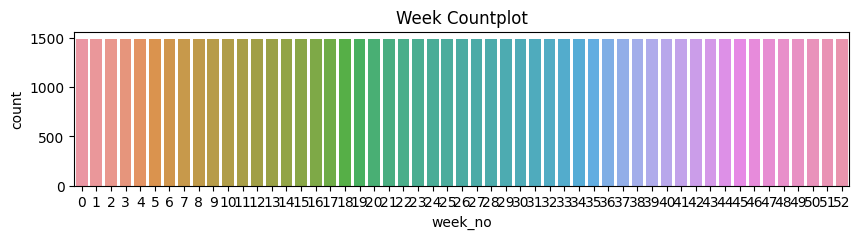

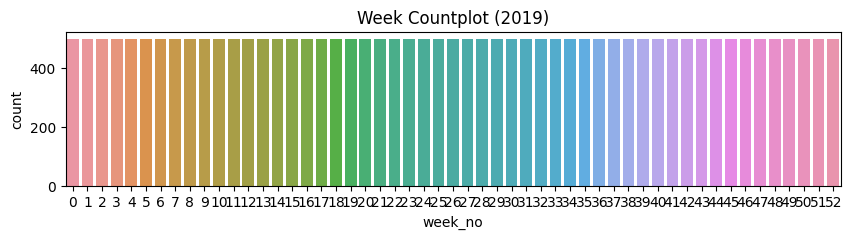

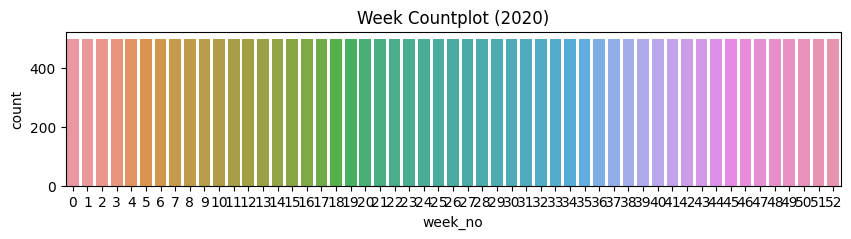

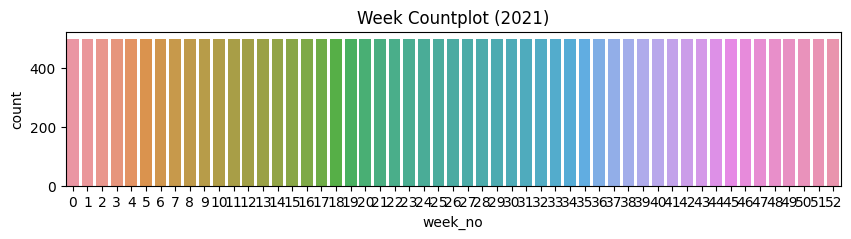

In [19]:
plt.figure(figsize=(10,2))
sns.countplot(x='week_no', data=train_data)
plt.title('Week Countplot')
plt.show()

plt.figure(figsize=(10,2))
sns.countplot(x='week_no', data=train_data[train_data['year']==2019])
plt.title('Week Countplot (2019)')
plt.show()

plt.figure(figsize=(10,2))
sns.countplot(x='week_no', data=train_data[train_data['year']==2020])
plt.title('Week Countplot (2020)')
plt.show()

plt.figure(figsize=(10,2))
sns.countplot(x='week_no', data=train_data[train_data['year']==2021])
plt.title('Week Countplot (2021)')
plt.show()

#each week has the same amount of data points as well, and each year contains equal data for all weeks
# datapoints are evenly spread across the weeks and years

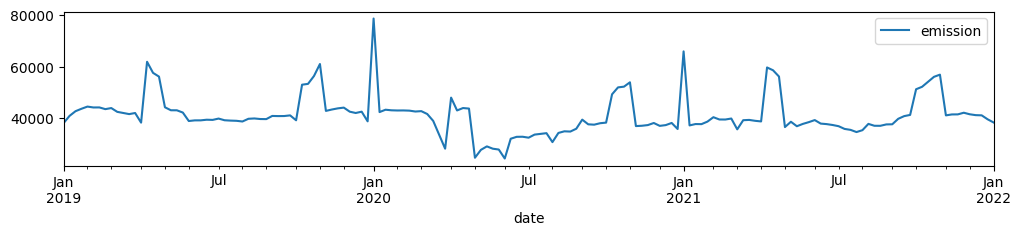

In [20]:
# to analyse the entire data as a time series, we'll consider the sum of weekly emissions
train_data['date'] = pd.to_datetime(train_data['year'].astype(str) + train_data['week_no'].astype(str) + '0', format='%Y%W%w')
weekly_emissions = train_data.groupby(['date'])[['emission']].sum()
weekly_emissions.plot(figsize=(12,2))
plt.show()

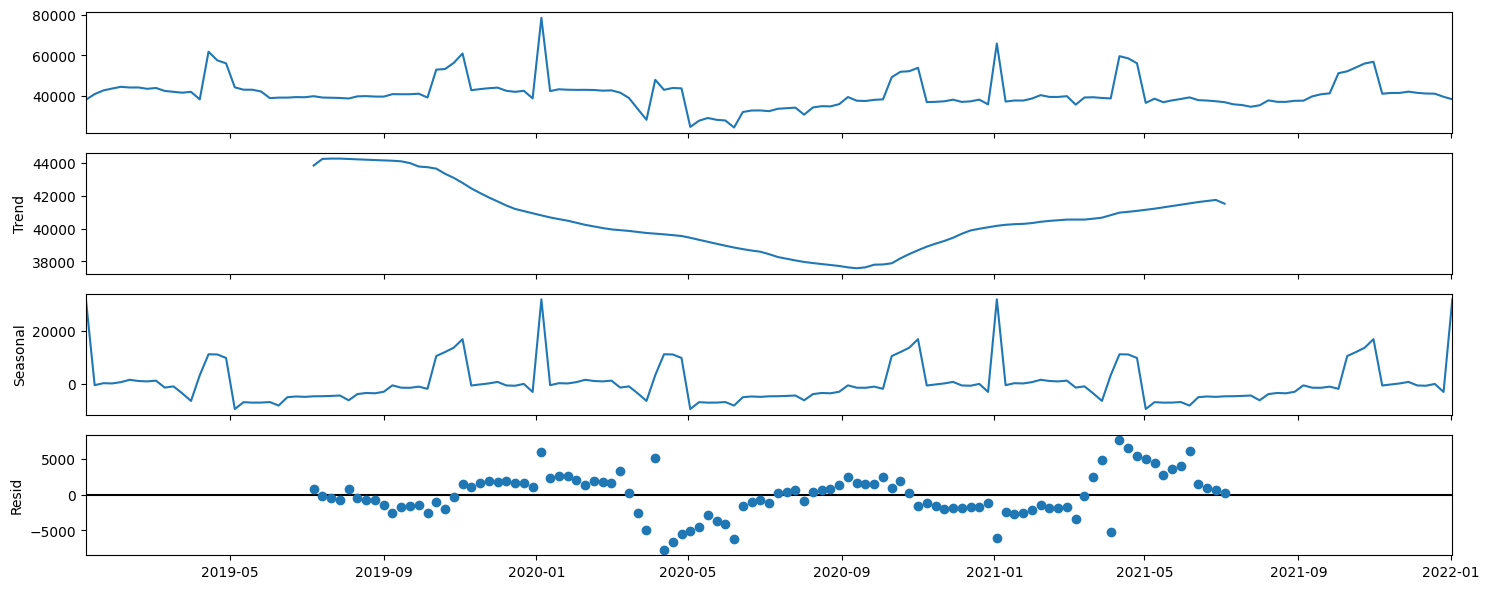

In [21]:
#let's look at its TSA decomposition

import statsmodels.api as sm

rcParams['figure.figsize'] = (15,6)
decomposition = sm.tsa.seasonal_decompose(weekly_emissions, model='additive',period=52)
fig = decomposition.plot()
plt.show()

# we see a decreasing trend in 2020, which can be attributed to COVID.
# Near 2020 end, the emissions start rising again

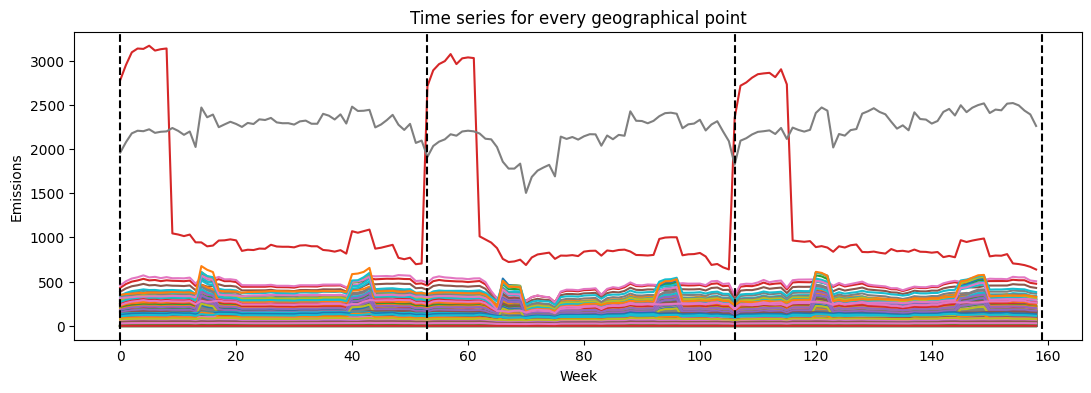

In [22]:
#now let's plot the time series of different geo points together

plt.figure(figsize=(13,4))
for _,point in train_data[['latitude','longitude']].drop_duplicates().iterrows():
    ts = train_data[(train_data['latitude']==point.latitude)&(train_data['longitude']==point.longitude)].emission
    plt.plot(range(len(ts)),ts)

plt.title('Time series for every geographical point')
for week in [0, 53, 106, 159]:
    plt.axvline(week, color='k', linestyle='--')

plt.xlabel('Week')
plt.ylabel('Emissions')
plt.show()

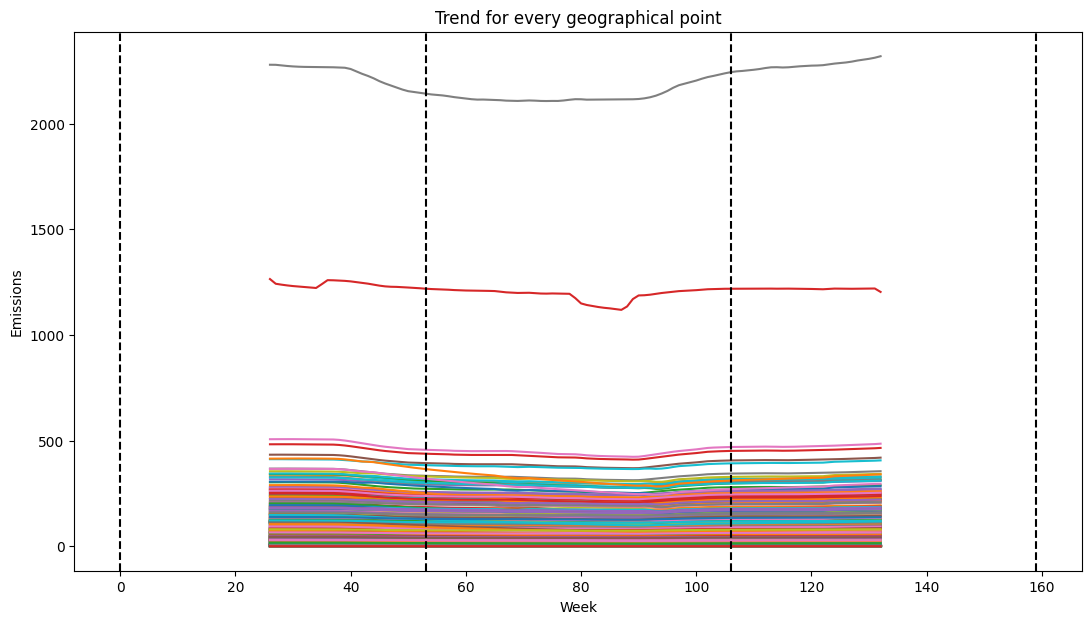

In [23]:
# let's look at each point's trend to see if there are any anomalies
plt.figure(figsize=(13,7))
for _,point in train_data[['latitude','longitude']].drop_duplicates().iterrows():
    ts = train_data[(train_data['latitude']==point.latitude)&(train_data['longitude']==point.longitude)].emission
    decomp = sm.tsa.seasonal_decompose(ts, model='additive',period=52)
    plt.plot(range(len(decomp.trend)),decomp.trend)

plt.title('Trend for every geographical point')
for week in [0, 53, 106, 159]:
    plt.axvline(week, color='k', linestyle='--')

plt.xlabel('Week')
plt.ylabel('Emissions')
plt.show()

# all series dip at least a little in 2020 and then rise again
# the lowest emitting geo points don't seem to be affected much

Feature Analysis

In [24]:
train_data.columns

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide

In [25]:
# we can pick the most correlated features to train our model on
top20_corrs = abs(train_data.drop(columns=['ID_LAT_LON_YEAR_WEEK']).corr()['emission']).sort_values(ascending = False).head(21)
top20_corrs
# as observed on the map earlier, latitude doesn't seem to be very correlated to a point's emission

emission                                                    1.000000
longitude                                                   0.102746
UvAerosolLayerHeight_aerosol_height                         0.069008
UvAerosolLayerHeight_aerosol_pressure                       0.068138
Cloud_surface_albedo                                        0.046587
CarbonMonoxide_H2O_column_number_density                    0.043217
CarbonMonoxide_CO_column_number_density                     0.041328
Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.040263
UvAerosolLayerHeight_aerosol_optical_depth                  0.040156
UvAerosolLayerHeight_sensor_azimuth_angle                   0.035142
NitrogenDioxide_solar_azimuth_angle                         0.033417
Formaldehyde_tropospheric_HCHO_column_number_density        0.033333
SulphurDioxide_solar_azimuth_angle                          0.032338
Formaldehyde_solar_azimuth_angle                            0.030815
NitrogenDioxide_sensor_altitude   

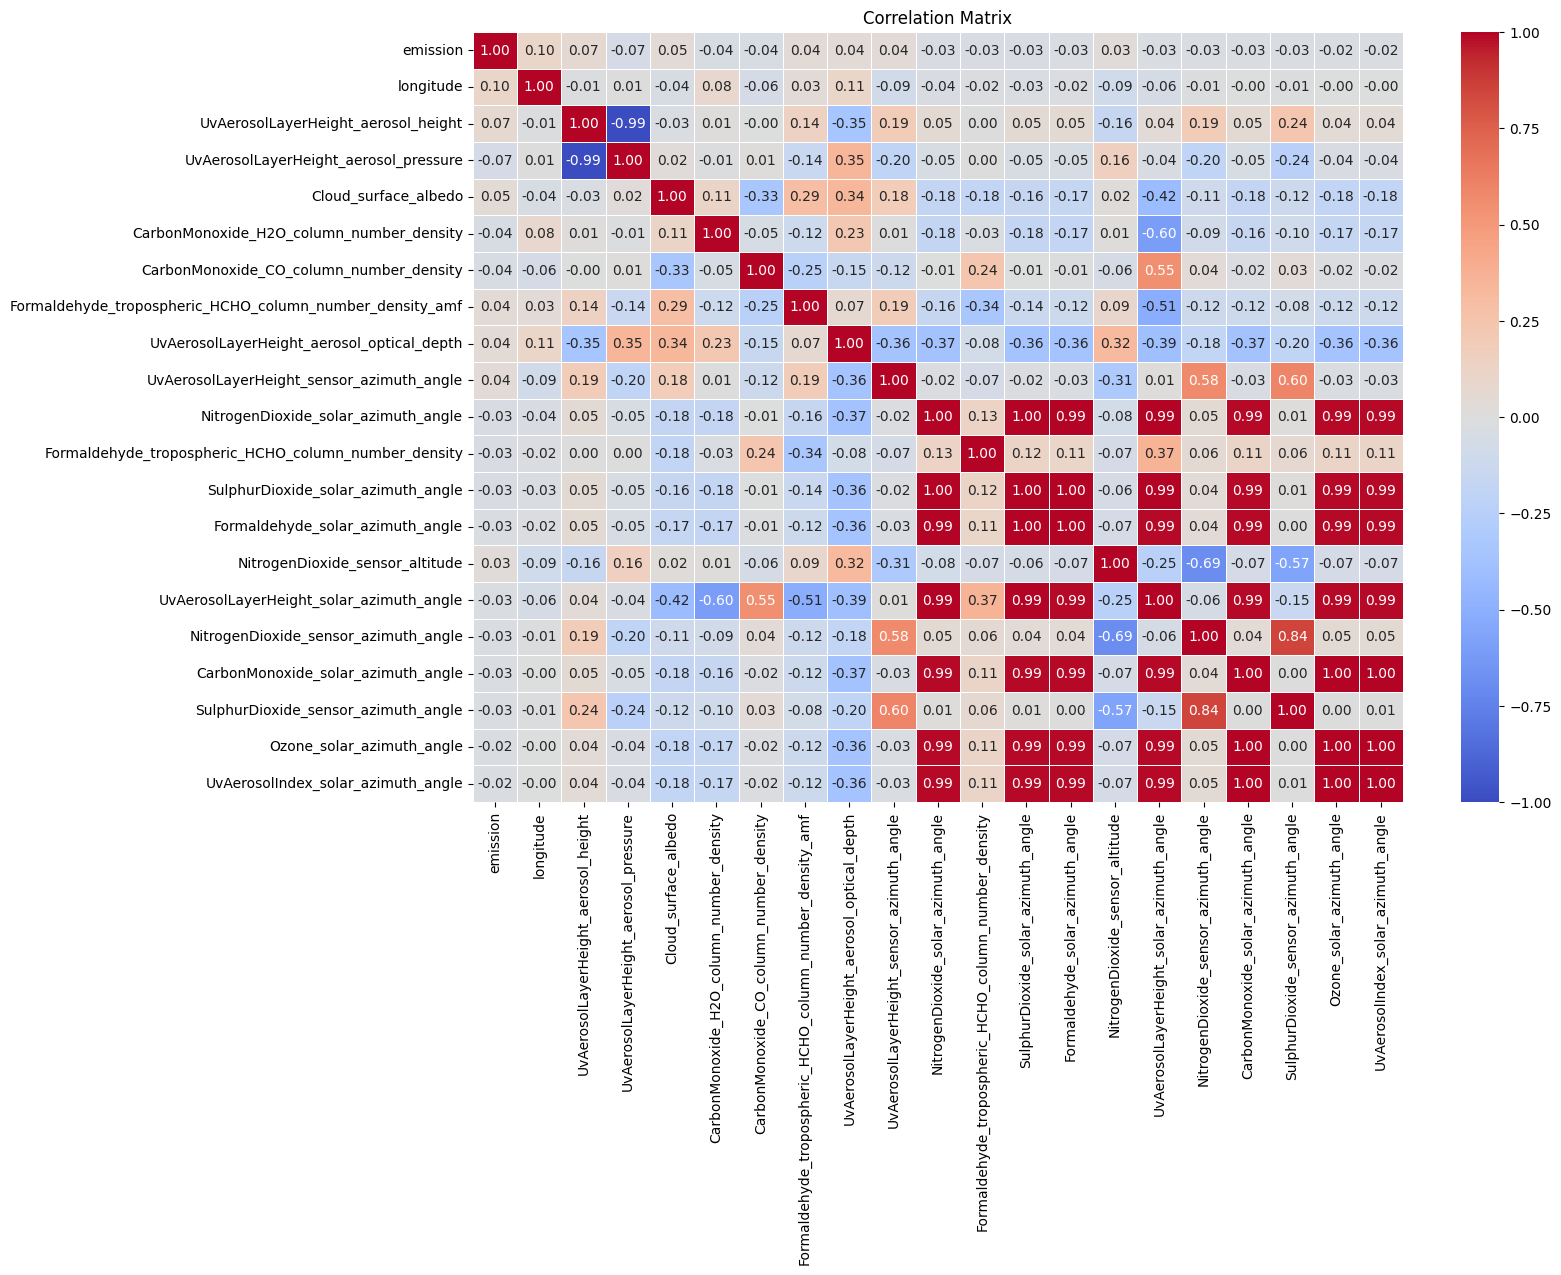

In [26]:
corr_matrix=train_data[list(top20_corrs.keys())].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# we can see that some variables are highly correlated. 
# for starters, we can pick 3 features to train our model on (in addition to year and week_no)
# the first should intuitively be longitude already
# UvAerosolLayerHeight_aerosol_height is not correlated to longitude, so let this be the 2nd feature
# UvAerosolLayerHeight_aerosol_pressure is almost perfectly negatively correlated to vAerosolLayerHeight_aerosol_height, so we don't get any new info and skip this feature
# 

Decision Tree Classifier

In [36]:
# the data is non linear, so linear regression definitely will not work.
# let's try out a Decision tree Classifier
# However, as observed in the time series decomposition, the year 2020 was an outlier due to covid. We will need to drop the 2020 data to avoid polluting our predictions
# Additionally, we'll have to handle the missing values. Since we have geographical data, let's use knn imputer to impute these missing values

# Handling missing values

train_data = train_data.sort_values(by='longitude')
train_nocovid = train_data[(train_data.year == 2019) |
                       (train_data.year == 2020) & (train_data.week_no <= 8) |
                       (train_data.year == 2021) & (train_data.week_no > 8)]
geo_df_list.sort() #geo_df_list is a list of all distinct points. 
geo_df_list
n= len(geo_df_list)

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
columns_to_impute = ['CarbonMonoxide_H2O_column_number_density',  'UvAerosolLayerHeight_aerosol_height', 'Cloud_surface_albedo']
imputed_values = imputer.fit_transform(train_nocovid[columns_to_impute])
imputed_df = pd.DataFrame(imputed_values, columns=columns_to_impute, index=train_nocovid.index)
train_nocovid.loc[:, columns_to_impute] = imputed_df
test_imputed = imputer.fit_transform(test_data[columns_to_impute])
test_data[columns_to_impute] = pd.DataFrame(test_imputed, columns=columns_to_impute, index=test_data.index)
        


In [37]:
print(test_data[columns_to_impute+['longitude', 'week_no']].isna().sum())

CarbonMonoxide_H2O_column_number_density    0
UvAerosolLayerHeight_aerosol_height         0
Cloud_surface_albedo                        0
longitude                                   0
week_no                                     0
dtype: int64


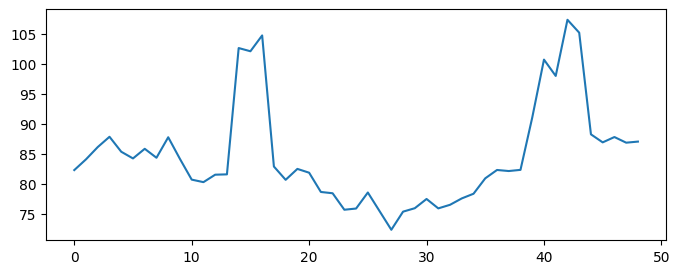

In [38]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(train_nocovid[columns_to_impute+['longitude', 'week_no']], train_nocovid.emission)
y_pred = model.predict(test_data[columns_to_impute+['longitude', 'week_no']])
submission_nocovid = pd.Series(y_pred, name='emission', index=test_data.index)
test_data['emission'] = submission_nocovid

plt.figure(figsize=(8,3))
plt.plot(range(49),submission_nocovid.groupby(test_data.week_no).mean())


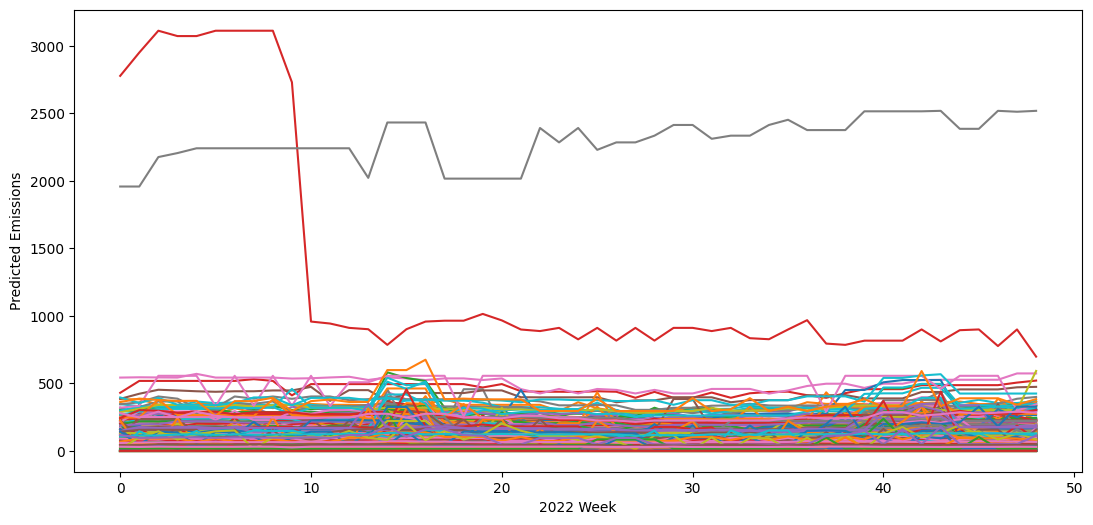

In [39]:
#let's plot the individual emissions

plt.figure(figsize=(13,6))
for _,point in test_data[['latitude','longitude']].drop_duplicates().iterrows():
    ts = test_data[(test_data['latitude']==point.latitude)&(test_data['longitude']==point.longitude)].emission
    plt.plot(range(49),ts)

plt.xlabel('2022 Week')
plt.ylabel('Predicted Emissions')
plt.show()

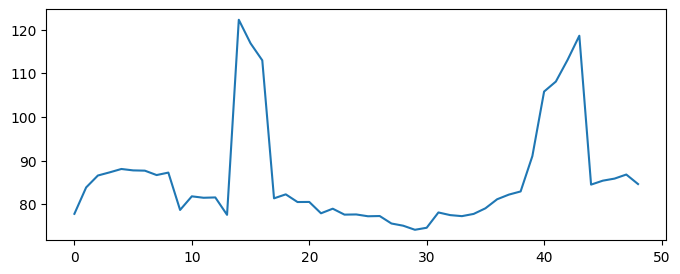

In [40]:
# let's also try a decision tree regressor with columns with no missing values - week, latitude and longitude

model = DecisionTreeRegressor()
model.fit(train_nocovid[['longitude', 'latitude', 'week_no']], train_nocovid.emission)
y_pred = model.predict(test_data[['longitude', 'latitude', 'week_no']])
submission_nocovid = pd.Series(y_pred, name='emission', index=test_data.index)

plt.figure(figsize=(8,3))
plt.plot(range(49),submission_nocovid.groupby(test_data.week_no).mean())

#since submissions are closed, I can't really check the accuracy of the predictions right now
# the overall trend in these predicitons is the same

Time Series Approach

In [ ]:
# now, as seen from the time series decomposition of the 497 geo points, the emissions themselves seem to be pretty correlated. 
# As suggested in Abrosm's discussion post, we can perform PCA on these 497 emissions

emission = train_data.pivot(index=['latitude', 'longitude'], 
                       columns=['year', 'week_no'], values='emission')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
emission_standardized = scaler.fit_transform(emission)
pca = PCA(n_components=10) 
emission_pca = pca.fit_transform(emission_standardized)

In [ ]:
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

plt.figure(figsize=(8,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance')
plt.show()

# we see that the first 5 components themselves cover almost all of the variance shon by the data. 
# Thus, it suffices to make predictions for these 5 principal components instead of all 497 geo points!

In [ ]:
emission.columns = ['_'.join([str(col[0]),str(col[1])]) for col in emission.columns]
plt.figure(figsize=(13, 5))
components=pca.components_[:5]
df=pd.DataFrame(components,columns= emission.columns)
for i, row in df.iterrows():
    plt.plot(df.columns,row, label=f'Component {i}')

for week in [0, 53, 106, 159]:
    plt.axvline(week, color='k', linestyle='--')

plt.xlabel('Features')
plt.ylabel('Component Value')
plt.title('Principal Components')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90, ha='center')
plt.show()

# we observe that - 
# 1. Component 1 peaks in Jan and Feb
# 2. Component 2 rises in May and October
# 3. Component 3 shows sudden peak after Februrary - possibly due to covid